Our preliminary tests showed, that Optigrid performed well on Data of November 2018. In this notebook we will explore a few other months and look for similarities and descrepancies in the results. We will use preprocessed data, where things like source stability and voltage breakdowns are indicated. Moreover, for now we will limit ourselfs to stable running sources, i.e. time periods with a low variance and a high current in the BCT25. We use the already preprocessed datasets.

### Module loading
We use the Python modules from the ionsrcopt package that will be loaded in the next cells.

In [1]:
# %load ../ionsrcopt/load_data.py
import pandas as pd
import numpy as np

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    if 'Timestamp (UTC_TIME)' in df.columns:
        print("Converting column \'{}\' to \'{}\'".format('Timestamp (UTC_TIME)', 'datetime'))
        df['Timestamp (UTC_TIME)'] = pd.to_datetime(df['Timestamp (UTC_TIME)']) 
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'IP.SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df

def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    if 'ITF.BCT15:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT15:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITF.BCT25:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT25:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITH.BCT41:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT41:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITL.BCT05:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT05:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:OVEN1AQNP'].apply(lambda x: np.nan if x < 4.5 else x)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.SOLEXT.ACQUISITION:CURRENT'].apply(lambda x: np.nan if x < 1200 else x)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:BIASDISCAQNV'].apply(lambda x: np.nan if x == 0 else x)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.SAIREM2:FORWARDPOWER'].apply(lambda x: np.nan if x < 500 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x > 2.5 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x < 0.5 else x)
    
    return df

In [2]:
# %load ../../../optigrid/grid_level.py
class GridLevel:
    """ Optigrid creates a nested partition of the input space. This data structure is used to represent a single level of the grid. Either it represents a cluster or it is devided further into subgrids """

    def __init__(self, cutting_planes, cluster_index):
        """ Creates a grid level.

        Parameters:
            cutting_planes (list): The planes that are used to subdivide this grid level or None if it represents a cluster
            cluster_index (int): The index of the represented cluster or None if it can be subdivided further
        """

        self.cutting_planes = cutting_planes
        self.cluster_index = cluster_index
        self.subgrids = []
        self.subgrid_indices = []

    def add_subgrid(self, subgrid_index, subgrid):
        """ Add a deeper level to the grid

        Parameters:
            subgrid_index (int): For every cutting plane, the subgrid can lay either right or left. This information can be used to binary encode it all at once. This is the subgrid index
            subgrid (GridLevel): The subgrid to add
        """

        self.subgrid_indices.append(subgrid_index)
        self.subgrids.append(subgrid)

    def get_sublevel(self, datapoint):
        """ For a given datapoint returns the subgrid it lies in
        
        Parameters: 
            datapoint (ndarray): The datapoint
        
        Returns:
            GridLevel: The subgrid or -1 if it belongs to no subgrid, meaning the point is an outlier.
        """

        if datapoint is None:
            raise ValueError("Datapoint must not be None.")

        grid_index = 0
        for i, cut in enumerate(self.cutting_planes):
            if datapoint[cut[1]] > cut[0]:
                grid_index += 2 ** i

        if not grid_index in self.subgrid_indices:
            return -1

        return self.subgrids[self.subgrid_indices.index(grid_index)]

In [3]:
# %load ../../../optigrid/optigrid.py
import numpy as np
from sklearn.neighbors import KernelDensity

#from grid_level import GridLevel

class Optigrid:
    """ Implementation of the Optigrid Algorithm described in "Optimal Grid-Clustering: Towards Breaking the Curse of Dimensionality in High-Dimensional Clustering" by Hinneburg and Keim """

    def __init__(self, d, q, max_cut_score, noise_level, kde_kernel='gaussian', kde_bandwidth = 0.1, kde_grid_ticks=100, kde_num_samples=15000, kde_atol=1E-6, kde_rtol=1E-4, verbose=False):
        """ 
        Parameters:
            d (int): Dimension of the data
            q (int): Number of cutting planes per iteration
            max_cut_score (double): Maximum density of a cutting plane
        """

        self.d = d
        self.q = q
        self.max_cut_score = max_cut_score
        self.noise_level = noise_level

        self.root = None
        self.clusters = None
        self.num_clusters = -1

        self.kde_kernel = kde_kernel
        self.kde_bandwidth = kde_bandwidth
        self.kde_grid_ticks = kde_grid_ticks
        self.kde_num_samples = kde_num_samples
        self.kde_atol = kde_atol
        self.kde_rtol = kde_rtol

        self.verbose = verbose

    def fit(self, data):
        """ Find all clusters in the data. Clusters are stored as indices pointing to the passed data, i.e. if '10' is in cluster '0' means, that data[10] is in cluster 0.

        Parameters:
            data (ndarray): Each datapoint has to be an array of d dimensions
        """

        data_count = len(data)
        cluster_indices = np.array(range(data_count))

        grid, clusters = self._iteration(data=data, cluster_indices=cluster_indices, percentage_of_values=1, last_cluster_name = [-1])
        self.root = grid
        self.clusters = clusters
        self.num_clusters = len(clusters)

        if self.verbose:
            print("Optigrid found {} clusters.".format(self.num_clusters))

    def _iteration(self, data, cluster_indices, percentage_of_values, last_cluster_name):
        """ Do one recursive step of the optigrid algorithm.

        Parameters:
            data (ndarray): Each datapoint has to be an array of d dimensions
            cluster_indices (list of int): All indices that belong to the current cluster
            percentage_of_values (double): Percentage of values that lay in the current cluster (0-1)
            current_cluster (int): (passed as list to be mutable) The last cluster name that was found, -1 if none

        Returns:
            GridLevel: The gridlevel at the current step with all its depth
            list of list of int: All clusters in the current data chunk
        """

        cuts_iteration = []
        for i in range(self.d): # First create all best cuts
            cuts_iteration += self._create_cuts_kde(data, cluster_indices, current_dimension=i, percentage_of_values=percentage_of_values)
        
        if not cuts_iteration:
            last_cluster_name[0] += 1
            if self.verbose:
                print("Found cluster {}".format(last_cluster_name[0]))

            return GridLevel(cutting_planes=None, cluster_index=last_cluster_name[0]), [cluster_indices]
    
        cuts_iteration = sorted(cuts_iteration, key=lambda x: x[2])[:self.q] # Sort the cuts based on the density at the minima and select the q best ones
        grid = GridLevel(cutting_planes=cuts_iteration, cluster_index=None)
        
        grid_data = self._fill_grid(data, cluster_indices, cuts_iteration) # Fill the subgrid based on the cuts
    
        result = []
        for i, cluster in enumerate(grid_data):
            if cluster.size==0:
                continue
            if self.verbose:
                print("In current cluster: {:.2f}% of datapoints".format(percentage_of_values*len(cluster)/len(cluster_indices)*100))
            subgrid, subresult = self._iteration(data=data, cluster_indices=cluster, percentage_of_values=percentage_of_values*len(cluster)/len(cluster_indices), last_cluster_name=last_cluster_name) # Run Optigrid on every subgrid
            grid.add_subgrid(i, subgrid)
            result += subresult

        return grid, result

    def _fill_grid(self, data, cluster_indices, cuts):
        """ Partitions the grid based on the selected cuts and assignes each cell the corresponding data points (as indices).
        
        Parameters:
            data (ndarray): Each datapoint has to be an array of d dimensions
            cluster_indices (list of int): All indices that belong to the current cluster
            cuts (list): Cutting planes in the format (position, dimension, cutting_score)

        Returns:
            list of list of int: 2**num_cuts lists of indices representing the clusters in this level
        """
        
        num_cuts = len(cuts)
        grid_index = np.zeros(len(cluster_indices))
        for i, cut in enumerate(cuts):
            cut_val = 2 ** i
            grid_index[np.take(np.take(data, cut[1], axis=1), cluster_indices) > cut[0]] += cut_val

        return [cluster_indices[grid_index==key] for key in range(2**num_cuts)]
    
    def _create_cuts_kde(self, data, cluster_indices, current_dimension, percentage_of_values):
        """ Find the best cuts in the specified dimension by estimating the data density using kde.

        Parameters:
            data (ndarray): Each datapoint has to be an array of d dimensions
            cluster_indices (list of int): All indices that belong to the current cluster
            current_dimension (int): Dimension on which to project
            percentage_of_values (double): Percentage of values that lay in the current cluster (0-1)

        Returns:
            list: q best cuts in the format (position, dimension, cutting_score)
        """

        grid, kde = self._estimate_distribution(data, cluster_indices, current_dimension, percentage_of_values=percentage_of_values) 
        kde = np.append(kde, 0)

        peaks = self._find_peaks_distribution(kde)      
        if not peaks:
            return []

        peaks = [peaks[0]] + sorted(sorted(peaks[1:-1], key=lambda x: kde[x], reverse=True)[:self.q - 1]) + [peaks[len(peaks) - 1]] # and get the q-1 most important peaks between the leftest and rightest one.
        best_cuts = self._find_best_cuts(grid, kde, peaks, current_dimension)
        return best_cuts

    def _find_best_cuts(self, grid, kde, peaks, current_dimension):
        """ Using a density estimate and its maxima, finds the best cutting planes
        
        Parameters:
            grid (list of double): The grid on which the density estimate was evaluated
            kde (list of double): For each point on the grid the corresponding density
            peaks (list of double): The maxima of the density estimate on the grid
            current_dimension (int): Dimension on which the data is projected

        Returns:
            list: Best cutting planes in this dimension in the format (position, dimension, cutting_score)
        """
        best_cuts = [] 
        for i in range(len(peaks)-1): # between these peaks search for the optimal cutting plane
            current_min = 1
            current_min_index = -1
            for j in range(peaks[i]+1, peaks[i+1]):
                if kde[j] < current_min:
                    current_min = kde[j]
                    current_min_index = j
            
            if current_min_index >= 0 and current_min < self.max_cut_score:
                best_cuts.append((grid[current_min_index], current_dimension, current_min)) # cutting plane format: (cutting coordinate, dimension in which we cut, density at minimum)
        return best_cuts

    def _find_peaks_distribution(self, kde):
        """ Given a density distribution, locates its peaks

        Parameters:
            kde (list of double): The density estimates on an arbitrary 1D grid

        Returns:
            list of int: The corresponding indices of the grid where the kde has its peaks.
        """

        peaks=[]
        prev = 0
        current = kde[0]
        for bin in range(1, len(kde)): # Find all peaks that are above the noise level
            next = kde[bin] 
            if current > prev and current > next and current >= self.noise_level:
                peaks.append(bin-1)
            prev = current
            current = next
        return peaks

    def _estimate_distribution(self, data, cluster_indices, current_dimension, percentage_of_values):
        """ Estimate the distribution using a sample of the data projected to a coordinate axis using scikits kde estimate method

        Parametes:
            data (ndarray): Each datapoint has to be an array of d dimensions
            cluster_indices (list of int): All indices that belong to the current cluster
            current_dimension (int): Dimension on which to project
            percentage_of_values (double): Percentage of values that lay in the current cluster (0-1)

        Returns:
            list of double: A equally spaced grid
            list of double: The density on the grid points
        """
        
        sample_size = min(self.kde_num_samples, len(cluster_indices))
        sample = np.random.choice(cluster_indices, size=sample_size)
        datapoints = np.expand_dims(data[sample][:,current_dimension], -1)
        min_val = np.amin(datapoints)
        max_val = np.amax(datapoints)

        kde = KernelDensity(kernel=self.kde_kernel, bandwidth=self.kde_bandwidth, atol=self.kde_atol, rtol=self.kde_rtol).fit(datapoints)

        grid = np.linspace([min_val], [max_val], self.kde_grid_ticks)
        log_dens = kde.score_samples(grid)
        return grid, np.exp(log_dens) * percentage_of_values

    def score_samples(self, samples):
        """ For every sample calculates the cluster it belongs to

        Parameters:
            samples (list of ndarray): The sample to score. They need to have the same dimensionality and scale as the data optigrid was fitted with
        
        Returns:
            list of int: For every sample, the cluster it belongs to or None if it is in no cluster (only possible for q>1)
        """

        return [self._score_sample(sample) for sample in samples]

    def _score_sample(self, sample):
        """ Score a single sample

        Parameters:
            sample (ndarray): Needs to have the same dimensionality and scale as the data optigrid was fitted with

        Returns:
            int: Cluster the sample belongs to ore None
        """

        if self.root is None:
            raise Exception("Optigrid needs to be fitted to a dataset first.")

        current_grid_level = self.root
        while current_grid_level.cluster_index is None:
            sub_level = current_grid_level.get_sublevel(sample)
            if sub_level is None:
                return None
            
            current_grid_level = sub_level

        return current_grid_level.cluster_index

First, we need to specifiy all the columns we are interested in. There are three types: Parameters, these are the ones that will be clustered later on, Measurments and columns from preprocessing.

In [4]:
time = ['Timestamp (UTC_TIME)']
parameters = ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN', 'IP.SOLCEN.ACQUISITION:CURRENT', 'IP.SOLEXT.ACQUISITION:CURRENT', 'IP.NSRCGEN:OVEN1AQNP', 'ITF.BCT25:CURRENT']
measurments = ['ITF.BCT25:CURRENT']
preprocessing = ['source_stable', 'is_breakdown']
columns_to_load = time + parameters + measurments + preprocessing

Next, specify the important files..

In [5]:
input_folder = '../Data_Preprocessed/'
input_file = 'Nov2018.csv'
input_path = input_folder + input_file
output_folder = '../Data_Clustered/'
output_file = input_file
output_path = output_folder + input_file

cluster_logfile = output_folder + 'cluster_runs.log'

...and load them.

In [18]:
df_total = read_data_from_csv(input_path, columns_to_load, None)
df_total = convert_column_types(df_total)
df_total.dropna(inplace=True)

Loading data from csv file '../Data_Preprocessed/Nov2018.csv'
Started type conversion of columns...
Converting column 'Timestamp (UTC_TIME)' to 'datetime'
Converting column 'IP.NSRCGEN:BIASDISCAQNV' to 'float32'
Converting column 'IP.NSRCGEN:GASSASAQN' to 'float32'
Column 'IP.NSRCGEN:SOURCEHTAQNI' does not exist
Column 'IP.SAIREM2:FORWARDPOWER' does not exist
Converting column 'IP.SOLCEN.ACQUISITION:CURRENT' to 'float32'
Converting column 'IP.SOLEXT.ACQUISITION:CURRENT' to 'float32'
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Converting column 'ITF.BCT25:CURRENT' to 'float32'
Column 'ITH.BCT41:CURRENT' does not exist
Column 'ITL.BCT05:CURRENT' does not exist


In [7]:
df_total.head(0)

,Timestamp (UTC_TIME),IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASSASAQN,IP.NSRCGEN:OVEN1AQNP,IP.SOLCEN.ACQUISITION:CURRENT,IP.SOLEXT.ACQUISITION:CURRENT,ITF.BCT25:CURRENT,is_breakdown,source_stable


Now we select what data we are interested in.

In [8]:
def select_values(df_total, parameters, source_stability, voltage_breakdown):
    return df_total[source_stability & voltage_breakdown][parameters].values

Once the data is ready we can begin clustering. But first we standard scale it, so that all parameters have the same variance.

In [9]:
from sklearn import preprocessing

def scale_values(values, scaler):
    if not scaler:
        scaler = preprocessing.StandardScaler().fit(values)
    values_scaled = scaler.transform(values)
    return scaler, values_scaled

The parameters for optigrid can be chosen by visually examening the distribution of normalized data, see below.

In [10]:
d=len(parameters)
q=1
max_cut_score = 0.3
noise_level = 0.1

optigrid_params = {
    'd' : d, 
    'q' : q, 
    'max_cut_score' : max_cut_score, 
    'noise_level' : noise_level, 
    'verbose' : False}

In [11]:
def run_optigrid(values_scaled, optigrid_params):
    optigrid = Optigrid(**optigrid_params)
    optigrid.fit(values_scaled)
    return optigrid

Once the clusters are found, we set an according column in the original dataframe containing all data.

In [12]:
def assign_clusters_df_total(df_total, optigrid, num_values, source_stability, voltage_breakdown_selection):
    clusters = np.zeros(num_values)

    for i, cluster in enumerate(optigrid.clusters):
        clusters[cluster] = i
    df_total.loc[source_stability & voltage_breakdown_selection, 'optigrid_cluster'] = clusters

And here we bundle all these steps together.

In [13]:
def cluster(df_total, parameters, source_stable, optigrid_params):
    print("Starting clustering for source stability {}".format(source_stable))
    source_stability = df_total['source_stable'] == source_stable
    voltage_breakdown_selection = df_total['is_breakdown'] > 0
    
    values = select_values(df_total, parameters, source_stability, ~voltage_breakdown_selection) # First, get the data without breakdowns,
    scaler, values_scaled = scale_values(values, None) # standard scale it
    optigrid = run_optigrid(values_scaled, optigrid_params) # and compute the clusters.
    assign_clusters_df_total(df_total, optigrid, len(values), source_stability, ~voltage_breakdown_selection) # Then, assign the found clusters to the original dataframe in a new column 'optigrid_clusters'
    
    print("Scoring voltage breakdowns")
    values = select_values(df_total, parameters, source_stability, voltage_breakdown_selection) # Now, get the datapoints when the voltage broke down
    _, values_scaled = scale_values(values, scaler) # scale it to the same ranges
    scored_samples = optigrid.score_samples(values_scaled) # and find the corresponding clusters.
    df_total.loc[source_stability & voltage_breakdown_selection, 'optigrid_cluster'] = scored_samples

In [14]:
df_total['optigrid_cluster'] = np.nan
cluster(df_total, parameters, 1, optigrid_params)
cluster(df_total, parameters, 0, optigrid_params)

Starting clustering for source stability 1
Scoring voltage breakdowns
Starting clustering for source stability 0
Scoring voltage breakdowns


#### Long term storage
We will save the clustered data to a file.

First, create the logging string.

In [15]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")

logstring = "[{}] \'{}\' cluster results saved to \'{}\'. Columns used: {}. Parameters used: {}.".format(dt_string, input_path, output_path, parameters, optigrid_params)
with open(cluster_logfile, "a") as myfile:
    myfile.write(logstring)

logstring

"[20.11.2019 10:31:44] '../Data_Preprocessed/Nov2018.csv' cluster results saved to '../Data_Clustered/Nov2018.csv'. Columns used: ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN', 'IP.SOLCEN.ACQUISITION:CURRENT', 'IP.SOLEXT.ACQUISITION:CURRENT', 'IP.NSRCGEN:OVEN1AQNP', 'ITF.BCT25:CURRENT']. Parameters used: {'d': 6, 'q': 1, 'max_cut_score': 0.3, 'noise_level': 0.1, 'verbose': False}."

Now we can save the dataframe to a file.

In [16]:
df_total = df_total.astype({'optigrid_cluster' : 'int64'})
df_total[df_total.shift(1)==df_total] = np.nan
df_total.to_csv(output_path, index=False)

### Visualizations

The selection of the parameters for optigrid can be done by looking of the densities of the normalized parameters. 

In [19]:
source_stability = df_total['source_stable'] == 1
voltage_breakdown_selection = df_total['is_breakdown'] > 0
values = select_values(df_total, parameters, source_stability, ~voltage_breakdown_selection)
_, values_scaled = scale_values(values, None)

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,10)

def estimate_distribution(data, cluster_indices, current_dimension, num_steps, bandwidth = 0.1, percentage_of_values=1, num_kde_samples=15000):
    sample_size = min(num_kde_samples, len(cluster_indices))
    sample = np.random.choice(cluster_indices, size=sample_size)
    datapoints = np.expand_dims(data[sample][:,current_dimension], -1)
    min_val = np.amin(datapoints)
    max_val = np.amax(datapoints)
    grid = np.linspace([min_val], [max_val], num_steps)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth, atol=1E-6, rtol=1E-4).fit(datapoints)
    log_dens = kde.score_samples(grid)
    return grid, np.exp(log_dens) * percentage_of_values

def plot_cluster(data, cluster_indices, parameters, parameter_ranges, median, resolution, bandwidth, percentage_of_values, num_kde_samples):
    if isinstance(bandwidth, float):
        bandwidth = [bandwidth for i in range(len(parameters))]
    
    fig = plt.figure()
    plt.title('Densities of specified parameters')
    
    for i, parameter in enumerate(parameters):
        grid, kde = estimate_distribution(data, cluster_indices, i, resolution, bandwidth=bandwidth[i], percentage_of_values=percentage_of_values, num_kde_samples=num_kde_samples)
        ax = plt.subplot('1{}{}'.format(len(parameters), i+1))
        ax.set_title("{}".format(parameter), fontsize=22)
        ax.tick_params(axis='both', which='major', labelsize=18)
        if parameter_ranges:
            ax.set_xlim(*parameter_ranges[i])
            #ax.set_ylim(*parameter_ranges[i][1])
            
        if median is not None:
            ax.axvline(x=median[i], color='red')
        
        ax.plot(grid, kde)
    
    plt.suptitle('Densities of specified parameters', fontsize=24)
    plt.show()

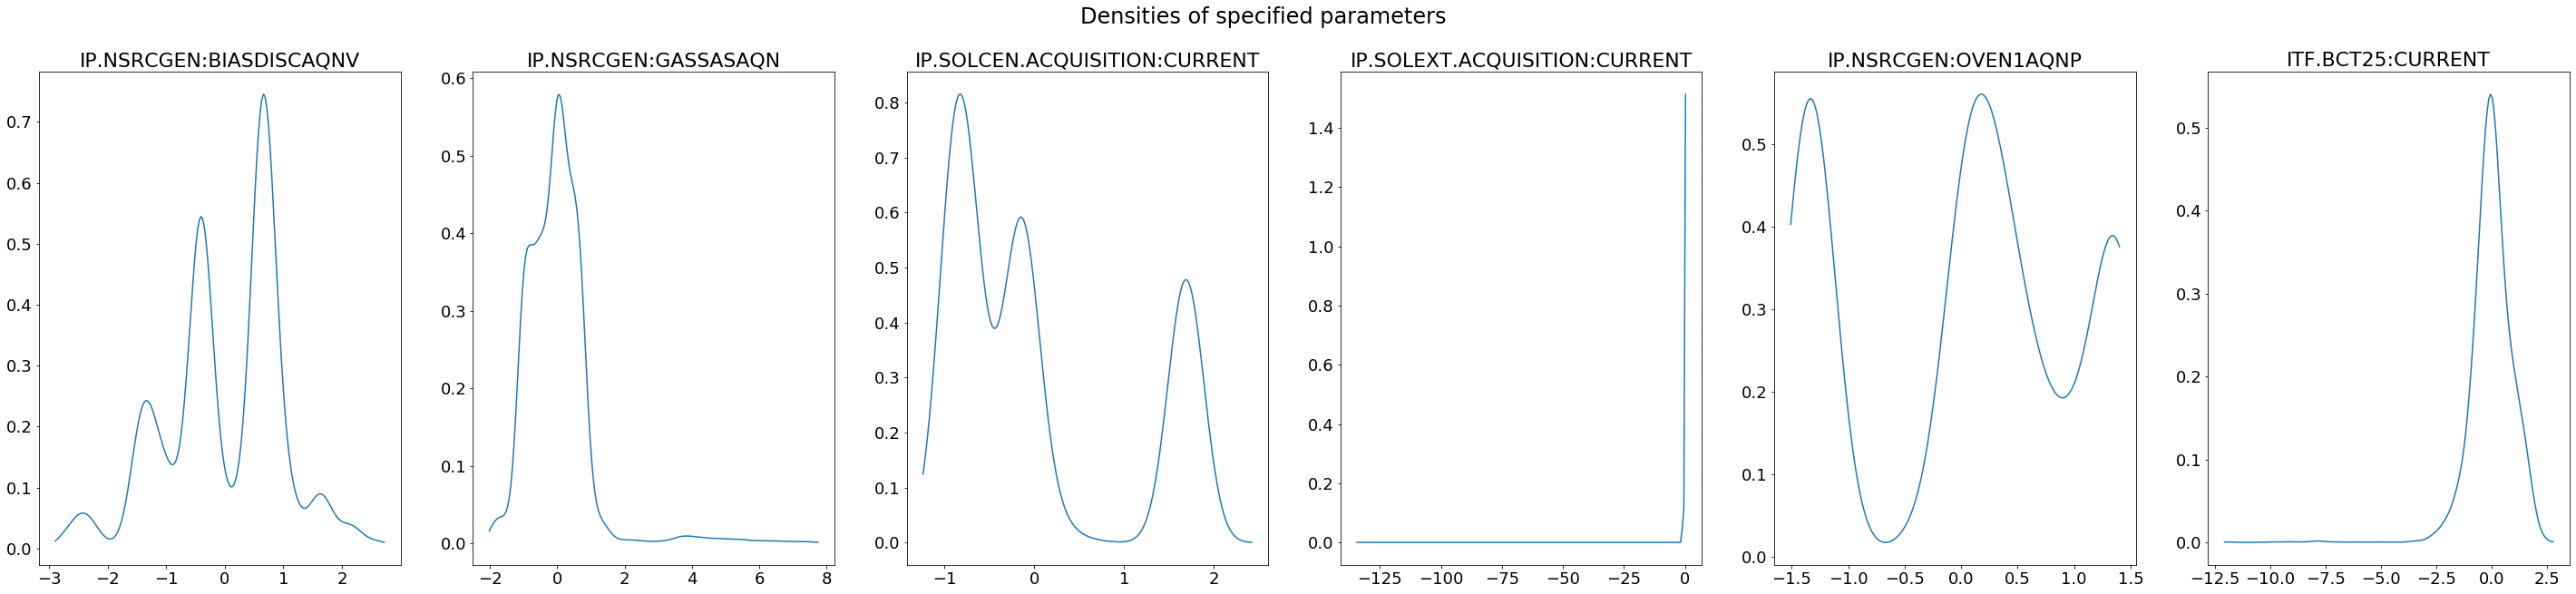

In [23]:
cluster_indices = np.array(range(0, len(values_scaled)))
resolution = 200
bandwidth = 0.2

num_kde_samples = 40000

plot_cluster(values_scaled, cluster_indices, parameters, parameter_ranges=None, median=None, resolution=resolution, bandwidth=bandwidth, percentage_of_values=1, num_kde_samples=num_kde_samples)

Based on these graphs we chose the noise level to be 0.1 and the max_cut_score, i.e. the maximum density where we still do a cut between two peaks, as 0.3

In [ ]:
def describe_clusters(optigrid, data, parameters):
    values = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    result = pd.DataFrame(columns = pd.MultiIndex.from_tuples([(p, v) for p in parameters for v in values] + [('DENSITY', 'count'), ('DENSITY', 'percentage')]))
    result.index.name = 'OPTIGRID_CLUSTER'
    
    for i, cluster in enumerate(optigrid.clusters):
        cluster_data = np.take(data, cluster, axis=0)
        mean = np.mean(cluster_data, axis=0)
        std = np.std(cluster_data, axis=0)
        quantiles = np.quantile(cluster_data, [0, 0.25, 0.5, 0.75, 1], axis=0)
        cluster_description = [[mean[i], std[i], quantiles[0][i], quantiles[1][i], quantiles[2][i], quantiles[3][i], quantiles[4][i]] for i in range(len(parameters))]
        cluster_description = [item for sublist in cluster_description for item in sublist]
        cluster_description.append(len(cluster))
        cluster_description.append(len(cluster)/len(data)*100)
        result.loc[i] = cluster_description
    return result

described = describe_clusters(optigrid, data, parameters)

In [ ]:
pd.set_option('display.max_columns', 500)
wanted_statistics = [[(param, 'mean'), (param, 'std')] for param in parameters]
wanted_statistics = [item for sublist in wanted_statistics for item in sublist] + [('DENSITY', 'percentage')]

num_of_clusters_to_print = 10
described.sort_values(by=[('DENSITY', 'percentage')], ascending=False, inplace = True)
print("Sum of densities of printed clusters: {:.1f}%".format(described.head(n=num_of_clusters_to_print)[('DENSITY', 'percentage')].sum()))
described.head(n=num_of_clusters_to_print)[wanted_statistics].round(3)

For visualizing the clusters we will plot the densities of the parameters. For comparability we will use explicit ranges for the x-axis per parameter. Those ranges should be chosen beforehand by an expert to validate or falsify his intuition.

In [ ]:
num_clusters = 6 # number of clusters to visualize
data = df[parameters].values # We select the unscaled data again, because by clustering we did not change any ordering and this data corresponds to the real world
num_datapoints = len(data)

resolution = 200
bandwidth = [1, 0.01, 1, 10, 0.1, 0.001]
num_kde_samples = 40000

parameter_ranges = [[0,0] for i in range(len(parameters))]
parameter_ranges[0] = [-300, -200] # Biasdisc x-axis

parameter_ranges[1] = [5.1, 5.3] # Gas x-axis
#parameter_ranges[2] = [0, 3] # High voltage current x-axis
parameter_ranges[2] = [200, 300] # SolCen current x-axis
#parameter_ranges[3] = [900, 2100] # Forwardpower x-axis
parameter_ranges[3] = [1200, 1300] # SolExt current x-axis
parameter_ranges[4] = [5, 20] # Oven1 power x-axis
parameter_ranges[5] = [0, 0.05] # BCT25 current x-axis

best_clusters = sorted(optigrid.clusters, key=lambda x: len(x), reverse=True)
for i, cluster in enumerate(best_clusters[:num_clusters]):
    median = [described.iloc[i,described.columns.get_loc((param, '50%'))] for param in parameters]
    plot_cluster(data, cluster, parameters, parameter_ranges, resolution=resolution, median=median, bandwidth=bandwidth, percentage_of_values=1, num_kde_samples=num_kde_samples)

Now, we want to find all high voltage breakdowns that correspond to the currently considered source stability, and find out to which cluster each datapoint belongs.

In [ ]:
wanted_statistics.append(('num_of_breakdowns', ''))
described.head(n=num_of_clusters_to_print)[wanted_statistics].round(3)

In [ ]:
wanted_statistics = [[(param, 'mean')] for param in parameters]
wanted_statistics = [item for sublist in wanted_statistics for item in sublist] + [('num_of_breakdowns', '')]
corr_described = described[wanted_statistics].corr()
corr_described.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [ ]:
pd.set_option('display.max_columns', 500)
wanted_statistics = [[(param, 'mean'), (param, 'std'),  (param, 'min'),  (param, 'max')] for param in parameters]
wanted_statistics = [item for sublist in wanted_statistics for item in sublist]
df_breakdowns.groupby('is_breakdown').describe()[wanted_statistics].round(2)